# Test mini_tVAE

### 1. Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mfacotti/martin/tVAE_project')
from mini_tvae_v2 import MiniTVAE

from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.metadata import Metadata

### 2. Load data

In [2]:
def load_rhc_data():
    """Load the RHC dataset and metadata."""
    try:
        # Load the CSV file
        data = pd.read_csv('../rhc.csv')
        
        # Load the metadata file
        with open('../metadata.json', 'r') as f:
            metadata = json.load(f)
            
        # Extract discrete columns from metadata
        discrete_columns = []
        for column, info in metadata.get('columns', {}).items():
            if info.get('type') == 'categorical' or info.get('sdtype') == 'categorical':
                discrete_columns.append(column)
                
        # If no discrete columns found in metadata, try to infer them
        if not discrete_columns:
            print("No discrete columns found in metadata. Inferring from data types...")
            for col in data.columns:
                if data[col].dtype == 'object' or data[col].dtype == 'category':
                    discrete_columns.append(col)
        
        print(f"Loaded RHC dataset with {data.shape[0]} rows and {data.shape[1]} columns")
        print(f"Identified {len(discrete_columns)} discrete columns")
        
        return data, discrete_columns
        
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        exit(1)

data, discrete_columns = load_rhc_data()

No discrete columns found in metadata. Inferring from data types...
Loaded RHC dataset with 5735 rows and 63 columns
Identified 21 discrete columns


### 3. Data preprocessing

In [3]:
# First approach
def clean_data(data):
    """Basic data cleaning and handling missing values."""
    # Handle missing values
    for column in data.columns:
        if data[column].dtype == 'object' or data[column].dtype == 'category':
            # For categorical columns, fill with the most frequent value
            mode_value = data[column].mode()[0]
            data[column] = data[column].fillna(mode_value)
        else:
            # For numerical columns, fill with the median
            data[column] = data[column].fillna(data[column].median())
    
    return data


data = clean_data(data)
data.head()

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,MOSF w/Sepsis,Yes,11142,11151.0,11831.5,11382,No,0,...,No,No,No,No,No,0.0,1927.0,white,Under $11k,5
1,2,MOSF w/Sepsis,MOSF w/Sepsis,No,11799,11844.0,11844.0,11844,Yes,1,...,No,No,Yes,No,No,0.0,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,11831.5,12400,No,0,...,No,No,No,No,No,0.0,599.0,white,$25-$50k,9
3,4,ARF,MOSF w/Sepsis,No,11146,11183.0,11183.0,11182,Yes,0,...,No,No,No,No,No,0.0,1927.0,white,$11-$25k,10
4,5,MOSF w/Sepsis,MOSF w/Sepsis,No,12035,12037.0,12037.0,12036,Yes,0,...,No,No,No,No,No,0.0,64.0,white,Under $11k,11


### 4. Training

In [ ]:
def train_tvae_model(data, discrete_columns, hyperparams=None):
    """
    Create and train a MiniTVAE model with the provided hyperparameters.
    
    Parameters:
    -----------
    data : DataFrame
        The training data
    discrete_columns : list
        List of discrete/categorical columns
    hyperparams : dict, optional
        Dictionary of hyperparameters for the MiniTVAE model
        
    Returns:
    --------
    MiniTVAE
        The trained model
    """
    # Default hyperparameters
    default_params = {
        'embedding_dim': 128,
        'compress_dims': (128, 128),
        'decompress_dims': (128, 128),
        'l2scale': 1e-5,
        'batch_size': 500,
        'epochs': 1000,
        'loss_factor': 2,
        'cuda': True, # Set to False if running on CPU
        'verbose': True
    }
    
    # Use provided hyperparameters or default values
    params = default_params.copy()
    if hyperparams:
        params.update(hyperparams)
    
    print("Training Mini TVAE model with the following parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Create and train the model
    model = MiniTVAE(**params)
    model.fit(data, discrete_columns)
    
    return model

# add feature to save model
model = train_tvae_model(data, discrete_columns)

Training Mini TVAE model with the following parameters:
  embedding_dim: 128
  compress_dims: (128, 128)
  decompress_dims: (128, 128)
  l2scale: 1e-05
  batch_size: 500
  epochs: 1000
  loss_factor: 2
  cuda: True
  verbose: True


/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/mfacotti/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate dat

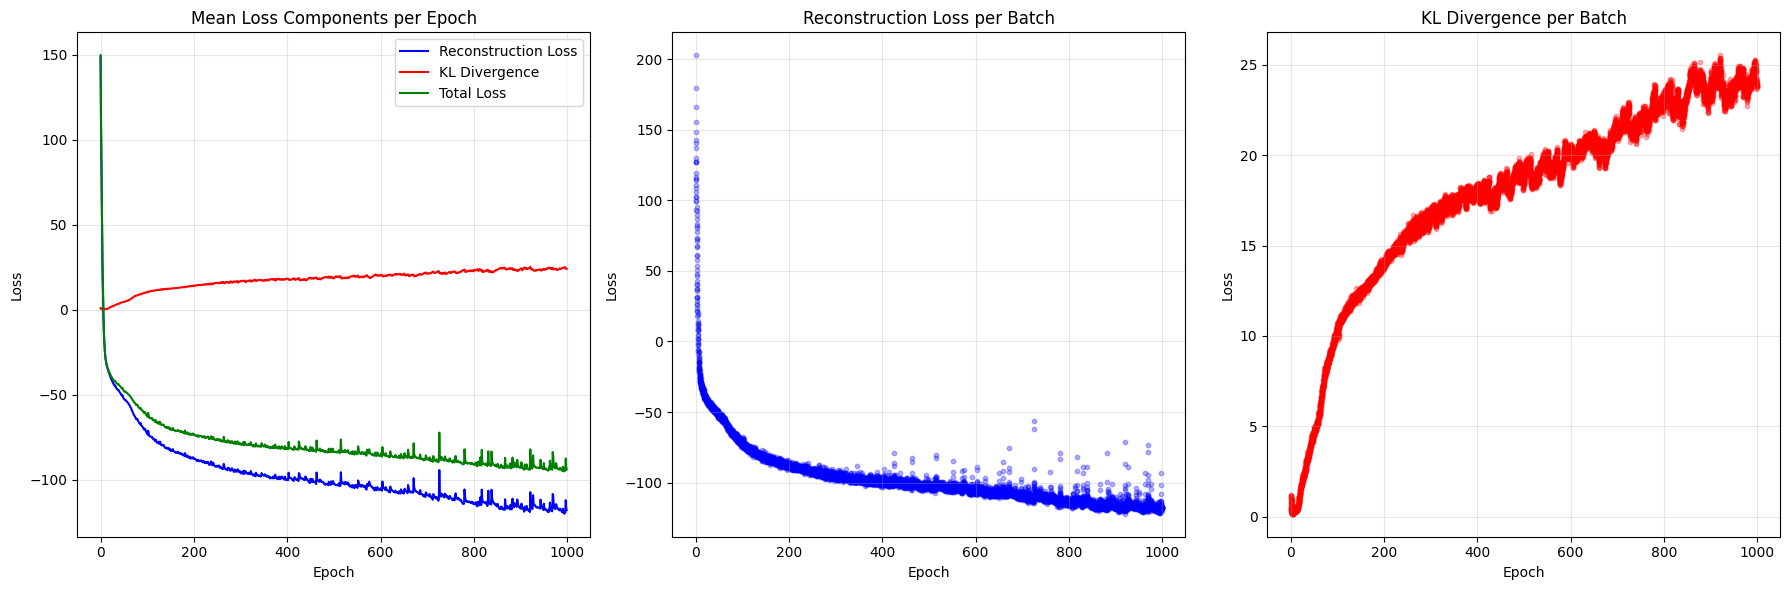

In [5]:
def plot_loss_over_epochs(loss_values):
    """Plot the loss components across epochs."""
    # Group by epoch and calculate mean loss components per epoch
    epoch_loss = loss_values.groupby('Epoch')[['loss_1', 'loss_2', 'total_loss']].mean().reset_index()
    
    plt.figure(figsize=(18, 6))
    
    # Plot mean loss components per epoch
    plt.subplot(1, 3, 1)
    plt.plot(epoch_loss['Epoch'], epoch_loss['loss_1'], 'b-', label='Reconstruction Loss')
    plt.plot(epoch_loss['Epoch'], epoch_loss['loss_2'], 'r-', label='KL Divergence')
    plt.plot(epoch_loss['Epoch'], epoch_loss['total_loss'], 'g-', label='Total Loss')
    plt.title('Mean Loss Components per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot batch reconstruction losses across epochs
    plt.subplot(1, 3, 2)
    for epoch in sorted(loss_values['Epoch'].unique()):
        epoch_data = loss_values[loss_values['Epoch'] == epoch]
        plt.scatter([epoch] * len(epoch_data), epoch_data['loss_1'], 
                    alpha=0.3, s=10, color='blue')
    plt.title('Reconstruction Loss per Batch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot batch KL divergence losses across epochs
    plt.subplot(1, 3, 3)
    for epoch in sorted(loss_values['Epoch'].unique()):
        epoch_data = loss_values[loss_values['Epoch'] == epoch]
        plt.scatter([epoch] * len(epoch_data), epoch_data['loss_2'], 
                    alpha=0.3, s=10, color='red')
    plt.title('KL Divergence per Batch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    
plot_loss_over_epochs(model.loss_values)

### 5. Generation

In [7]:
def generate_synthetic_data(model, num_samples, save_path=None):
    """
    Generate synthetic data from the trained model.
    
    Parameters:
    -----------
    model : MiniTVAE
        The trained model
    num_samples : int
        Number of samples to generate
    save_path : str, optional
        Path to save the synthetic data
        
    Returns:
    --------
    DataFrame
        The generated synthetic data
    """
    print(f"Generating {num_samples} synthetic samples...")
    synthetic_data = model.sample(num_samples)
    
    if save_path:
        synthetic_data.to_csv(save_path, index=False)
        print(f"Synthetic data saved to '{save_path}'")
    
    return synthetic_data

generate_synthetic_data(model, 10000, 'synthetic_rhc.csv') # or fit the number of samples to the original dataset with len(data)


Generating 10000 synthetic samples...
Synthetic data saved to 'synthetic_rhc.csv'


,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,4437,ARF,MOSF w/Sepsis,No,11399,11408.008917,12492.774003,12473,Yes,0,...,No,No,No,No,No,-0.000275,1927.198576,white,Under $11k,8106
1,1441,MOSF w/Malignancy,MOSF w/Sepsis,Metastatic,12128,12053.741839,12367.636707,12317,Yes,0,...,No,No,Yes,No,No,-0.005663,1332.604915,white,$25-$50k,2994
2,1740,MOSF w/Malignancy,MOSF w/Sepsis,Yes,11065,11100.997614,11034.050136,11096,Yes,0,...,No,No,No,No,No,-0.002128,1916.875182,white,Under $11k,2930
3,365,ARF,MOSF w/Sepsis,Yes,11195,11229.574600,11261.503240,11260,Yes,0,...,No,No,No,No,No,0.003188,1935.230872,white,Under $11k,898
4,4394,CHF,MOSF w/Sepsis,No,12000,12282.358871,11836.187003,12403,No,0,...,No,No,No,No,No,5.409200,2324.080650,white,Under $11k,7664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2389,ARF,MOSF w/Sepsis,No,10974,11038.973296,11286.217340,11226,Yes,0,...,No,No,No,No,No,-0.002175,1920.474726,white,Under $11k,4865
9996,2061,Cirrhosis,MOSF w/Sepsis,No,11322,11107.993036,11442.244288,11577,Yes,0,...,No,No,No,No,No,-0.002032,1928.835919,white,$11-$25k,4291
9997,1317,CHF,MOSF w/Sepsis,No,11758,11768.029650,12095.871825,11799,Yes,1,...,No,No,No,No,No,0.001779,1931.697169,white,> $50k,2611
9998,4269,ARF,MOSF w/Sepsis,No,12256,12253.076562,12286.367832,12341,Yes,0,...,No,No,No,No,No,-0.000599,2241.269876,white,Under $11k,7362


In [11]:
def compare_statistics(original_data, synthetic_data, discrete_columns, 
                       num_numeric=5, num_categorical=3, num_categories=5, 
                       exclude_first_column=True):
    """
    Compare statistics between original and synthetic data.
    
    Parameters:
    -----------
    original_data : DataFrame
        The original data
    synthetic_data : DataFrame
        The synthetic data
    discrete_columns : list
        List of discrete/categorical columns
    num_numeric : int, optional
        Number of numeric columns to compare
    num_categorical : int, optional
        Number of categorical columns to compare
    num_categories : int, optional
        Number of categories to display per categorical column
    exclude_first_column : bool, optional
        Whether to exclude the first column (patient ID) from the comparison
        
    Returns:
    --------
    dict
        Dictionary containing statistical comparison metrics
    """
    print("Comparing statistics between original and synthetic data:")
    
    # Create a copy of the dataframes to avoid modifying the originals
    orig_data = original_data.copy()
    synth_data = synthetic_data.copy()
    
    # Exclude the first column (patient ID) if requested
    if exclude_first_column:
        first_col = orig_data.columns[0]
        print(f"Excluding first column (patient ID): {first_col}")
        orig_data = orig_data.drop(columns=[first_col])
        if first_col in synth_data.columns:
            synth_data = synth_data.drop(columns=[first_col])
    
    # Initialize results dictionary to store comparison metrics
    results = {
        'numeric': {},
        'categorical': {}
    }
    
    # Compare numeric columns
    numeric_columns = orig_data.select_dtypes(include=['number']).columns
    if len(numeric_columns) > 0:
        print("\nNumeric columns comparison:")
        for col in numeric_columns[:num_numeric]:
            # Calculate statistics for original data
            orig_mean = orig_data[col].mean()
            orig_std = orig_data[col].std()
            orig_min = orig_data[col].min()
            orig_max = orig_data[col].max()
            
            # Calculate statistics for synthetic data
            syn_mean = synth_data[col].mean()
            syn_std = synth_data[col].std()
            syn_min = synth_data[col].min()
            syn_max = synth_data[col].max()
            
            # Calculate differences
            mean_diff = abs(orig_mean - syn_mean)
            std_diff = abs(orig_std - syn_std)
            
            # Store results
            results['numeric'][col] = {
                'original': {'mean': orig_mean, 'std': orig_std, 'min': orig_min, 'max': orig_max},
                'synthetic': {'mean': syn_mean, 'std': syn_std, 'min': syn_min, 'max': syn_max},
                'difference': {'mean': mean_diff, 'std': std_diff}
            }
            
            # Print comparison
            print(f"\nColumn: {col}")
            print(f"  Original - Mean: {orig_mean:.4f}, Std: {orig_std:.4f}, Range: [{orig_min:.4f}, {orig_max:.4f}]")
            print(f"  Synthetic - Mean: {syn_mean:.4f}, Std: {syn_std:.4f}, Range: [{syn_min:.4f}, {syn_max:.4f}]")
            print(f"  Difference - Mean: {mean_diff:.4f}, Std: {std_diff:.4f}")
    
    # Compare categorical columns
    valid_discrete_columns = [col for col in discrete_columns if col in orig_data.columns]
    if len(valid_discrete_columns) > 0:
        print("\nCategorical columns comparison (value counts percentage):")
        for col in valid_discrete_columns[:num_categorical]:
            print(f"\nColumn: {col}")
            
            # Calculate distributions
            orig_counts = orig_data[col].value_counts(normalize=True).sort_index()
            syn_counts = synth_data[col].value_counts(normalize=True).sort_index()
            
            # Combine indices to ensure we show all categories
            all_cats = sorted(list(set(list(orig_counts.index) + list(syn_counts.index))))
            cat_results = {}
            
            # Print and store category comparisons
            for cat in all_cats[:num_categories]:
                orig_pct = orig_counts.get(cat, 0) * 100
                syn_pct = syn_counts.get(cat, 0) * 100
                diff_pct = abs(orig_pct - syn_pct)
                
                cat_results[cat] = {
                    'original': orig_pct,
                    'synthetic': syn_pct,
                    'difference': diff_pct
                }
                
                print(f"  {cat}: Original {orig_pct:.1f}%, Synthetic {syn_pct:.1f}%, Diff {diff_pct:.1f}%")
            
            # Store results for this column
            results['categorical'][col] = cat_results
    
    return results


stats = compare_statistics(data, generate_synthetic_data(model, len(data)), discrete_columns, exclude_first_column=True)

Generating 5735 synthetic samples...
Comparing statistics between original and synthetic data:
Excluding first column (patient ID): Unnamed: 0

Numeric columns comparison:

Column: sadmdte
  Original - Mean: 11638.6863, Std: 513.9678, Range: [10754.0000, 12441.0000]
  Synthetic - Mean: 11598.4373, Std: 459.5559, Range: [10695.0000, 12457.0000]
  Difference - Mean: 40.2490, Std: 54.4119

Column: dschdte
  Original - Mean: 11660.0708, Std: 513.4049, Range: [10757.0000, 12560.0000]
  Synthetic - Mean: 11595.3934, Std: 480.5175, Range: [10709.4853, 12529.7155]
  Difference - Mean: 64.6774, Std: 32.8874

Column: dthdte
  Original - Mean: 11781.1178, Std: 435.6276, Range: [10757.0000, 12783.0000]
  Synthetic - Mean: 11764.4910, Std: 446.8352, Range: [10700.1536, 12862.3400]
  Difference - Mean: 16.6268, Std: 11.2076

Column: lstctdte
  Original - Mean: 11781.2579, Std: 524.0942, Range: [10756.0000, 12644.0000]
  Synthetic - Mean: 11760.7719, Std: 503.8089, Range: [10715.0000, 12744.0000]
  D

### 3.Evaluation

In [10]:
data = pd.read_csv('../rhc.csv')
metadata = Metadata.load_from_json('../metadata.json')

# Load the synthetic data
synthetic_data = pd.read_csv('synthetic_rhc.csv')

In [11]:
diagnostic = run_diagnostic(
    real_data=data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |          | 0/63 [00:00<?, ?it/s]|

(1/2) Evaluating Data Validity: |██████████| 63/63 [00:00<00:00, 442.62it/s]|
Data Validity Score: 97.34%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 196.20it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 98.67%



In [12]:
quality_report = evaluate_quality(
    data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 63/63 [00:12<00:00,  5.20it/s]|
Column Shapes Score: 86.92%

(2/2) Evaluating Column Pair Trends: |██████████| 1953/1953 [00:19<00:00, 98.06it/s]| 
Column Pair Trends Score: 71.17%

Overall Score (Average): 79.05%



In [15]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,cat1,TVComplement,0.894321
1,cat2,TVComplement,0.710733
2,ca,TVComplement,0.945586
3,sadmdte,KSComplement,0.912921
4,dschdte,KSComplement,0.906518
...,...,...,...
56,ortho,TVComplement,0.998779
57,adld3p,TVComplement,0.000007
58,urin1,KSComplement,0.648789
59,race,TVComplement,0.802881


In [16]:
quality_report.get_details('Column Pair Trends')

,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,cat1,cat2,ContingencySimilarity,0.157600,NaN,NaN
1,cat1,ca,ContingencySimilarity,0.870874,NaN,NaN
2,cat1,sadmdte,ContingencySimilarity,0.774743,NaN,NaN
3,cat1,dschdte,ContingencySimilarity,0.816730,NaN,NaN
4,cat1,dthdte,ContingencySimilarity,0.531536,NaN,NaN
...,...,...,...,...,...,...
1825,adld3p,race,ContingencySimilarity,0.000000,NaN,NaN
1826,adld3p,income,ContingencySimilarity,0.000000,NaN,NaN
1827,urin1,race,ContingencySimilarity,0.314926,NaN,NaN
1828,urin1,income,ContingencySimilarity,0.319723,NaN,NaN


In [20]:
quality_report.get_visualization('Column Pair Trends')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': '<b>Column Pair</b><br>(%{x},%{y})<br><br>Similarity: %{z}<extra></extra>',
              'type': 'heatmap',
              'x': array(['cat1', 'cat2', 'ca', 'sadmdte', 'dschdte', 'dthdte', 'lstctdte',
                          'death', 'cardiohx', 'chfhx', 'dementhx', 'psychhx', 'chrpulhx',
                          'renalhx', 'liverhx', 'gibledhx', 'malighx', 'immunhx', 'transhx',
                          'amihx', 'age', 'sex', 'edu', 'surv2md1', 'das2d3pc', 't3d30', 'dth30',
                          'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1', 'resp1', 'temp1', 'pafi1',
                          'alb1', 'hema1', 'bili1', 'crea1', 'sod1', 'pot1', 'paco21', 'ph1',
                          'swang1', 'wtkilo1', 'dnr1', 'ninsclas', 'resp', 'card', 'neuro',
                          'gastr', 'renal', 'meta', 'hema', 'seps', 'trauma', 'ortho', 'adld3p',
                          'urin1', 'race', 'income'], dtype=object),
              'xaxis': 'x',
              'y': array(['cat1', 'cat2', 'ca', 'sadmdte', 'dschdte', 'dthdte', 'lstctdte',
                          'death', 'cardiohx', 'chfhx', 'dementhx', 'psychhx', 'chrpulhx',
                          'renalhx', 'liverhx', 'gibledhx', 'malighx', 'immunhx', 'transhx',
                          'amihx', 'age', 'sex', 'edu', 'surv2md1', 'das2d3pc', 't3d30', 'dth30',
                          'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1', 'resp1', 'temp1', 'pafi1',
                          'alb1', 'hema1', 'bili1', 'crea1', 'sod1', 'pot1', 'paco21', 'ph1',
                          'swang1', 'wtkilo1', 'dnr1', 'ninsclas', 'resp', 'card', 'neuro',
                          'gastr', 'renal', 'meta', 'hema', 'seps', 'trauma', 'ortho', 'adld3p',
                          'urin1', 'race', 'income'], dtype=object),
              'yaxis': 'y',
              'z': {'bdata': ('AAAAAAAA8D/TTWIQWDnEP6wcWmQ73+' ... '5H4XrUPzeJQWDl0OI/AAAAAAAA8D8='),
                    'dtype': 'f8',
                    'shape': '61, 61'}},
             {'coloraxis': 'coloraxis2',
              'customdata': {'bdata': ('AAAAAAAA8D8nMQisHFrsPycxCKwcWu' ... 'cW2c73wz8bL90kBoGVvwAAAAAAAPA/'),
                             'dtype': 'f8',
                             'shape': '27, 27'},
              'hovertemplate': ('<b>Correlation</b><br>(%{x},%{' ... ' %{customdata})<extra></extra>'),
              'type': 'heatmap',
              'x': array(['sadmdte', 'dschdte', 'dthdte', 'lstctdte', 'age', 'edu', 'surv2md1',
                          'das2d3pc', 't3d30', 'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1',
                          'resp1', 'temp1', 'pafi1', 'alb1', 'hema1', 'bili1', 'crea1', 'sod1',
                          'pot1', 'paco21', 'ph1', 'wtkilo1', 'urin1'], dtype=object),
              'xaxis': 'x2',
              'y': array(['sadmdte', 'dschdte', 'dthdte', 'lstctdte', 'age', 'edu', 'surv2md1',
                          'das2d3pc', 't3d30', 'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1',
                          'resp1', 'temp1', 'pafi1', 'alb1', 'hema1', 'bili1', 'crea1', 'sod1',
                          'pot1', 'paco21', 'ph1', 'wtkilo1', 'urin1'], dtype=object),
              'yaxis': 'y2',
              'z': {'bdata': ('AAAAAAAA8D8rhxbZzvfvP2Dl0CLb+e' ... 'g5tMh2vj85tMh2vp+KPwAAAAAAAPA/'),
                    'dtype': 'f8',
                    'shape': '27, 27'}},
             {'coloraxis': 'coloraxis2',
              'customdata': {'bdata': ('AAAAAAAA8D8rhxbZzvfvP2Dl0CLb+e' ... 'g5tMh2vj85tMh2vp+KPwAAAAAAAPA/'),
                             'dtype': 'f8',
                             'shape': '27, 27'},
              'hovertemplate': ('<b>Correlation</b><br>(%{x},%{' ... ' %{customdata})<extra></extra>'),
              'type': 'heatmap',
              'x': array(['sadmdte', 'dschdte', 'dthdte', 'lstctdte', 'age', 'edu', 'surv2md1',
                          'das2d3pc', 't3d30', 'aps1', 'scoma1', 'meanbp1', 'wblc1', 'h

In [ ]:
quality_report.get_visualization('Column Shapes')